In [12]:
!pip install scikit-image

import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms


import h5py

from scipy.stats import skew

from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern, hog
from skimage.measure import moments_hu

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from google.colab import drive
drive.mount('/content/drive')
project_dir = "/content/drive/MyDrive/PROJECT"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Root keys: ['cjdata']
Keys in cjdata: ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']
Label: 1


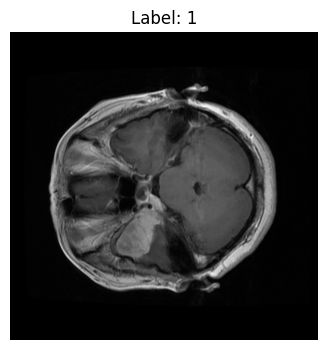

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

sample_file = os.path.join(project_dir, "brain_tumor_dataset", "1.mat")

with h5py.File(sample_file, 'r') as f:
    # List keys at the root level
    root_keys = list(f.keys())
    print("Root keys:", root_keys)

    # 'cjdata' should be one of the keys it is stored as a group.
    cjdata = f['cjdata']
    # List keys in cjdata
    cjdata_keys = list(cjdata.keys())
    print("Keys in cjdata:", cjdata_keys)
    image_data = np.array(cjdata['image'])

    # Access label, MATLAB indices are stored as 2D arrays, so we extract the first element.
    label = int(np.array(cjdata['label'])[0,0])

    print("Label:", label)

    # Normalizing the image to the 0-255 range for visualization
    im_norm = (image_data - image_data.min()) / (image_data.max() - image_data.min()) * 255
    sample_image = Image.fromarray(np.uint8(im_norm)).convert('L')

    # Displaying the image using matplotlib
    plt.figure(figsize=(4,4))
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


In [14]:
# Custom Dataset to load all .mat files with h5py
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import h5py
import numpy as np
from PIL import Image

class BrainTumorMatH5Dataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        # Gathering all .mat files
        self.mat_files = [f for f in os.listdir(root_dir) if f.endswith('.mat')]
        self.transform = transform

    def __len__(self):
        return len(self.mat_files)

    def __getitem__(self, idx):

        mat_path = os.path.join(self.root_dir, self.mat_files[idx])
        with h5py.File(mat_path, 'r') as f:
            cjdata = f['cjdata']
            image_data = np.array(cjdata['image']) # Load the image data
            label_array = np.array(cjdata['label']) # Load the label
            label = int(label_array[0,0])  # 1 (meningioma), 2 (glioma), 3 (pituitary)

        # Normalize image data to [0, 255] for better dynamic range
        im_norm = (image_data - image_data.min()) / (image_data.max() - image_data.min()) * 255
        image_pil = Image.fromarray(np.uint8(im_norm)).convert('L')

        # Apply transforms
        if self.transform:
            image_tensor = self.transform(image_pil)
        else:
            image_tensor = transforms.ToTensor()(image_pil)

        return image_tensor, label


In [15]:
dataset_dir = os.path.join(project_dir, "brain_tumor_dataset")
mat_files = sorted(
    [f for f in os.listdir(dataset_dir) if f.endswith('.mat')],
    key=lambda x: int(x.split('.')[0])
)

images_all = []
masks_all  = []
labels_all = []

for fname in mat_files:
    path = os.path.join(dataset_dir, fname)
    with h5py.File(path, 'r') as f:
        cj = f['cjdata']
        img = np.array(cj['image'])
        msk = np.array(cj['tumorMask'])
        lbl = int(np.array(cj['label'])[0,0]) - 1   # make 0,1,2
    images_all.append(img)
    masks_all.append(msk)
    labels_all.append(lbl)

labels_all = np.array(labels_all)

print("Loaded:",
      f"{len(images_all)} images of shape {images_all[0].shape},",
      f"{len(masks_all)} masks of shape {masks_all[0].shape},",
      f"{labels_all.shape[0]} labels")

classes = ['meningioma','glioma','pituitary']

Loaded: 3064 images of shape (512, 512), 3064 masks of shape (512, 512), 3064 labels


In [16]:
# Defines the common 5-fold splits
from sklearn.model_selection import StratifiedKFold
RNG  = 42
skf  = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
folds = list(skf.split(np.zeros(len(labels_all)), labels_all))
print("Prepared 5 folds with class balance:",
      [np.bincount(labels_all[test], minlength=3) for _, test in folds])


Prepared 5 folds with class balance: [array([142, 285, 186]), array([142, 285, 186]), array([142, 285, 186]), array([141, 286, 186]), array([141, 285, 186])]


In [17]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# One-fold (hold-out) loaders for quick sanity checks
val_transform = test_transform          # alias used later

HOLD_OUT = 0
train_idx, test_idx = folds[HOLD_OUT]

dataset_train = Subset(
    BrainTumorMatH5Dataset(dataset_dir, train_transform), train_idx)
dataset_test  = Subset(
    BrainTumorMatH5Dataset(dataset_dir, test_transform),  test_idx)

batch_size = 32
train_loader = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(dataset_test,  batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"HOLD-OUT fold {HOLD_OUT} : train:{len(dataset_train)}  test:{len(dataset_test)}")

dataset_dir = os.path.join(project_dir, "brain_tumor_dataset")


HOLD-OUT fold 0 : train:2451  test:613


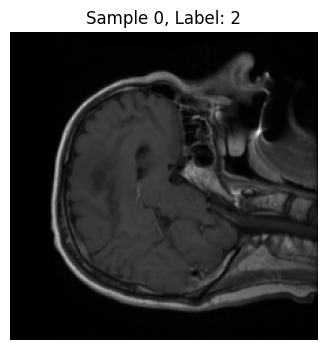

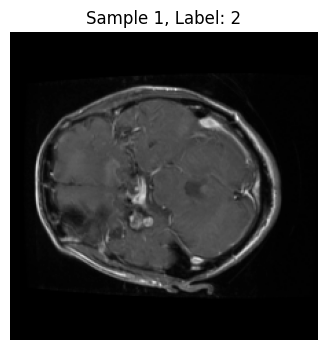

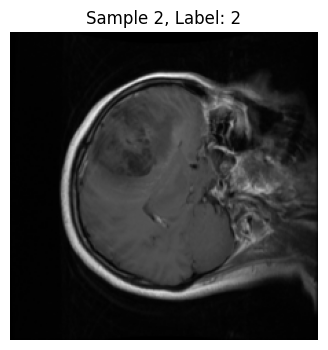

[2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [18]:
# Visualizing a few samples from the dataset
import matplotlib.pyplot as plt

for i in range(3):
    img_tensor, label = BrainTumorMatH5Dataset(dataset_dir, test_transform)[i]
    img_np = img_tensor.squeeze().numpy()

    plt.figure(figsize=(4,4))
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Sample {i}, Label: {label}")
    plt.axis('off')
    plt.show()

my_labels = []
for i in range(len(BrainTumorMatH5Dataset(dataset_dir, test_transform))):
    img_tensor, label = BrainTumorMatH5Dataset(dataset_dir, test_transform)[i]
    my_labels.append(label)

print(my_labels)

In [19]:
# Load cvind.mat and creating Train/Test Split
cvind_file = os.path.join(project_dir, "1512427", "cvind.mat")

import h5py
"""
with h5py.File(cvind_file, 'r') as f:
    raw = np.array(f['cvind'])        # shape (1, 3064)
cvind = raw.flatten().astype(np.int64) - 1  # now shape (3064,), values 0–4

print("cvind shape:", cvind.shape)
print("Fold counts:", np.bincount(cvind))

test_fold = 0
test_indices  = np.where(cvind == test_fold)[0]
train_indices = np.where(cvind != test_fold)[0]

print(f"Train size: {len(train_indices)}, Test size: {len(test_indices)}")

# Sanity check label distribution in test set
ytst = labels_all[test_indices]
counts = np.bincount(ytst, minlength=3)
print("Test-set distribution:",
      {classes[i]: int(counts[i]) for i in range(3)})
"""


'\n# Cell 6 (corrected): Load cvind.mat and create true train/test splits\nwith h5py.File(cvind_file, \'r\') as f:\n    raw = np.array(f[\'cvind\'])        # shape (1, 3064)\ncvind = raw.flatten().astype(np.int64) - 1  # now shape (3064,), values 0–4\n\nprint("cvind shape:", cvind.shape)\nprint("Fold counts:", np.bincount(cvind))\n\n# Choose fold #0 as test, the rest as train\ntest_fold = 0\ntest_indices  = np.where(cvind == test_fold)[0]\ntrain_indices = np.where(cvind != test_fold)[0]\n\nprint(f"Train size: {len(train_indices)}, Test size: {len(test_indices)}")\n\n# Sanity check label distribution in test set\nytst = labels_all[test_indices]\ncounts = np.bincount(ytst, minlength=3)\nprint("Test-set distribution:",\n      {classes[i]: int(counts[i]) for i in range(3)})\n'

In [20]:
# feature‐extractors for each pipeline

def extract_glcm_feats(img):
    """GLCM stats at 4 angles."""
    # convert to 0–255 uint8
    im = ((img - img.min())/(img.max()-img.min())*255).astype(np.uint8)
    glcm = graycomatrix(im,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256,
                        symmetric=True,
                        normed=True)
    feats = []
    for prop in ['contrast','correlation','energy','homogeneity']:
        vals = graycoprops(glcm, prop)
        feats.extend(vals.flatten())
    return np.array(feats)


def extract_lbp_feats(img):
    """Uniform LBP histogram."""
    im = ((img - img.min())/(img.max()-img.min())*255).astype(np.uint8)
    radius, n_pts = 3, 8*3
    lbp = local_binary_pattern(im, n_pts, radius, method='uniform')
    # histogram
    n_bins = int(lbp.max()+1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0,n_bins), density=True)
    return hist


def extract_shape_int_feats(img, mask):
    """First‐order stats of tumor region + 7 Hu moments."""
    region = img[mask.astype(bool)]
    if region.size>0:
        m, v = region.mean(), region.var()
        s = skew(region.flatten())
    else:
        m=v=s=0.0
    hu = moments_hu(mask.astype(np.uint8))
    return np.hstack(([m, v, s], hu))

from PIL import Image

def extract_hog_feats(img):
    """HOG descriptors on a 224×224 version of the image."""
    # 1) Normalize to 0–255 uint8
    im = ((img - img.min())/(img.max()-img.min())*255).astype(np.uint8)
    # 2) Resize to 224×224
    pil = Image.fromarray(im)
    pil = pil.resize((224, 224), resample=Image.BILINEAR)
    im_small = np.array(pil)
    # 3) Compute HOG
    feats = hog(
        im_small,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        orientations=9,
        block_norm='L2-Hys',
        feature_vector=True
    )
    return feats



In [21]:
# compute features for every sample
print("Extracting features for all samples…")
X_glcm   = np.array([extract_glcm_feats(images_all[i])          for i in range(len(images_all))])
X_lbp    = np.array([extract_lbp_feats(images_all[i])           for i in range(len(images_all))])
X_shape  = np.array([extract_shape_int_feats(images_all[i], masks_all[i])
                                                     for i in range(len(images_all))])
X_hog = np.array([extract_hog_feats(images_all[i]) for i in range(len(images_all))])

y_all    = labels_all

print("Shapes -> GLCM:", X_glcm.shape,
      "LBP:", X_lbp.shape,
      "Shape:", X_shape.shape,
      "HOG:", X_hog.shape)


Extracting features for all samples…
Shapes -> GLCM: (3064, 16) LBP: (3064, 26) Shape: (3064, 10) HOG: (3064, 6084)


In [22]:
# Classical Hyperparameter Tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

cv = folds

# 1) GLCM + SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale','auto'],
    'kernel': ['rbf','linear']
}
grid_svm = GridSearchCV(
    SVC(),
    param_grid=param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
print("Fitting GLCM+SVM grid...")
grid_svm.fit(X_glcm, labels_all)
print("Best SVM params:", grid_svm.best_params_)
print("SVM 5-fold CV accuracy: {:.3f} ± {:.3f}".format(
    grid_svm.cv_results_['mean_test_score'][grid_svm.best_index_],
    grid_svm.cv_results_['std_test_score'][grid_svm.best_index_]
))

# 2) LBP + Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
print("Fitting LBP+RF grid...")
grid_rf.fit(X_lbp, labels_all)
print("Best RF params:", grid_rf.best_params_)
print("RF 5-fold CV accuracy: {:.3f} ± {:.3f}".format(
    grid_rf.cv_results_['mean_test_score'][grid_rf.best_index_],
    grid_rf.cv_results_['std_test_score'][grid_rf.best_index_]
))

# 3) Shape+Intensity + Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}
grid_lr = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=param_grid_lr,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
print("Fitting Shape+LR grid...")
grid_lr.fit(X_shape, labels_all)
print("Best LR params:", grid_lr.best_params_)
print("LR 5-fold CV accuracy: {:.3f} ± {:.3f}".format(
    grid_lr.cv_results_['mean_test_score'][grid_lr.best_index_],
    grid_lr.cv_results_['std_test_score'][grid_lr.best_index_]
))

# 4) HOG + KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
print("Fitting HOG+KNN grid...")
grid_knn.fit(X_hog, labels_all)
print("Best KNN params:", grid_knn.best_params_)
print("KNN 5-fold CV accuracy: {:.3f} ± {:.3f}".format(
    grid_knn.cv_results_['mean_test_score'][grid_knn.best_index_],
    grid_knn.cv_results_['std_test_score'][grid_knn.best_index_]
))

# cross_val_score summary with the best estimators
print("\nFinal 5-fold CV summary (using best hyperparameters):")
classical_estimators = {
    "GLCM + SVM":  grid_svm.best_estimator_,
    "LBP + RF":    grid_rf.best_estimator_,
    "Shape + LR":  grid_lr.best_estimator_,
    "HOG + KNN":   grid_knn.best_estimator_
}

for name, clf in classical_estimators.items():
    scores = cross_val_score(clf,
                             X_glcm if "GLCM" in name else (X_lbp if "LBP" in name else (X_shape if "Shape" in name else X_hog)),
                             labels_all,
                             cv=cv,
                             scoring='accuracy',
                             n_jobs=-1)
    print(f"-> {name} CV acc: {scores.mean():.3f} ± {scores.std():.3f}")


Fitting GLCM+SVM grid...
Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVM 5-fold CV accuracy: 0.690 ± 0.010
Fitting LBP+RF grid...
Best RF params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
RF 5-fold CV accuracy: 0.891 ± 0.022
Fitting Shape+LR grid...
Best LR params: {'C': 0.01, 'max_iter': 1000, 'solver': 'lbfgs'}
LR 5-fold CV accuracy: 0.713 ± 0.012
Fitting HOG+KNN grid...
Best KNN params: {'n_neighbors': 3, 'weights': 'distance'}
KNN 5-fold CV accuracy: 0.964 ± 0.007

Final 5-fold CV summary (using best hyperparameters):
-> GLCM + SVM CV acc: 0.690 ± 0.010
-> LBP + RF CV acc: 0.891 ± 0.022
-> Shape + LR CV acc: 0.713 ± 0.012
-> HOG + KNN CV acc: 0.964 ± 0.007


In [34]:
classic_fold_scores = {}

for name, clf in classical_estimators.items():
    scores = cross_val_score(
        clf,
        X_glcm if "GLCM" in name else (X_lbp if "LBP" in name else
                (X_shape if "Shape" in name else X_hog)),
        labels_all,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
    )
    classic_fold_scores[name] = scores
    print(f"{name:12s} : {scores}")


GLCM + SVM   : [0.69331158 0.68189233 0.69168026 0.67699837 0.70588235]
LBP + RF     : [0.86460033 0.89722675 0.86786297 0.9233279  0.9003268 ]
Shape + LR   : [0.71615008 0.70636215 0.7177814  0.72920065 0.69444444]
HOG + KNN    : [0.95758564 0.97063622 0.96900489 0.96737357 0.95424837]


In [23]:
# simple CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        # Convolutional layers:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # Output: (16, 224, 224)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)                          # Output: (32, 224, 224)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)                          # Output: (64, 224, 224)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial size by factor 2

        # Compute output dimensions after 3 pooling operations (224 -> 112 -> 56 -> 28)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply convolution, activation, and pooling sequentially
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (16, 112, 112)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (32, 56, 56)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # (64, 28, 28)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=3)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [24]:
# training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        # Adjusting labels, subtract 1 so that classes become 0, 1, 2
        images, labels = images.to(device), (labels.to(device) - 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), (labels.to(device) - 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy


In [25]:
# Train SimpleCNN on HOLD-OUT fold
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fresh model
model = SimpleCNN(num_classes=3).to(device)

criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_model(model, train_loader, criterion, optimizer, device)
    te_loss, te_acc = evaluate_model(model, test_loader,  criterion, device)
    print(f"[SimpleCNN] Epoch {epoch:02d}/{num_epochs} -> "
          f"train acc {tr_acc:.4f} | val acc {te_acc:.4f}")


[SimpleCNN] Epoch 01/10 -> train acc 0.6663 | val acc 0.7716
[SimpleCNN] Epoch 02/10 -> train acc 0.7589 | val acc 0.8124
[SimpleCNN] Epoch 03/10 -> train acc 0.7952 | val acc 0.8108
[SimpleCNN] Epoch 04/10 -> train acc 0.8242 | val acc 0.8662
[SimpleCNN] Epoch 05/10 -> train acc 0.8454 | val acc 0.8711
[SimpleCNN] Epoch 06/10 -> train acc 0.8723 | val acc 0.8907
[SimpleCNN] Epoch 07/10 -> train acc 0.8882 | val acc 0.9054
[SimpleCNN] Epoch 08/10 -> train acc 0.9041 | val acc 0.9184
[SimpleCNN] Epoch 09/10 -> train acc 0.9135 | val acc 0.9168
[SimpleCNN] Epoch 10/10 -> train acc 0.9233 | val acc 0.9299


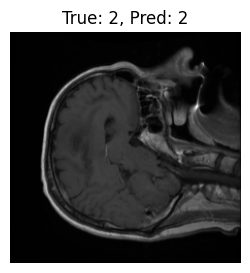

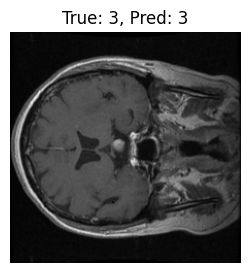

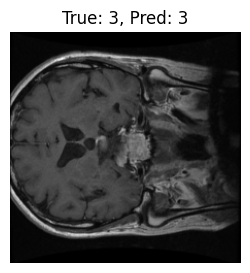

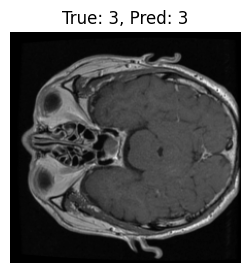

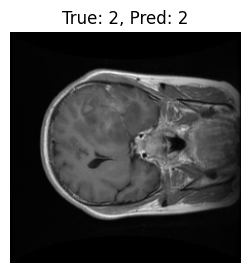

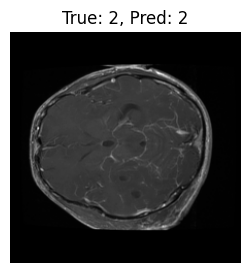

In [26]:
# Visualizing predictions from the test set
model.eval()
import numpy as np

images, labels = next(iter(test_loader))
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Adjusting labels back to original values for display
true_labels = (labels.to(device) - 1) + 1  # if we want to display as original label 1,2,3
pred_labels = preds + 1

import matplotlib.pyplot as plt
for i in range(min(6, images.size(0))):
    img_np = images[i].cpu().squeeze().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(img_np, cmap='gray')
    plt.title(f"True: {true_labels[i].item()}, Pred: {pred_labels[i].item()}")
    plt.axis("off")
    plt.show()

In [27]:
# 3-channel preprocessing for pretrained nets
from torchvision import transforms

preprocess_3c = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # gives [1×224×224]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),         # -> [3×224×224]
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# new dataset & loaders for deep nets
dataset_dir = os.path.join(project_dir, "brain_tumor_dataset")
dataset_3c = BrainTumorMatH5Dataset(root_dir=dataset_dir, transform=preprocess_3c)

from torch.utils.data import Subset, DataLoader

train_dataset_3c = Subset(dataset_3c, train_idx)
test_dataset_3c  = Subset(dataset_3c,  test_idx)

batch_size = 32
train_loader_3c = DataLoader(train_dataset_3c, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_3c  = DataLoader(test_dataset_3c,  batch_size=batch_size, shuffle=False, num_workers=2)


In [28]:
# ResNet18 Transfer-Learning
import torchvision.models as models
import torch.nn as nn

def create_resnet18(num_classes=3, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

resnet = create_resnet18(num_classes=3).to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# Training loop (reusing train_model/evaluate_model)
for epoch in range(1, 6):
    tr_loss, tr_acc = train_model(resnet, train_loader_3c, criterion, optimizer, device)
    te_loss, te_acc = evaluate_model(resnet, test_loader_3c, criterion, device)
    print(f"[ResNet18] Epoch {epoch}: Train {tr_acc:.4f} | Test {te_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


[ResNet18] Epoch 1: Train 0.8960 | Test 0.9364
[ResNet18] Epoch 2: Train 0.9763 | Test 0.9625
[ResNet18] Epoch 3: Train 0.9935 | Test 0.9723
[ResNet18] Epoch 4: Train 0.9955 | Test 0.9739
[ResNet18] Epoch 5: Train 0.9951 | Test 0.9788


In [29]:
# DenseNet121 Transfer-Learning
def create_densenet121(num_classes=3, pretrained=True):
    model = models.densenet121(pretrained=pretrained)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

densenet = create_densenet121(num_classes=3).to(device)
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-4)

for epoch in range(1, 6):
    tr_loss, tr_acc = train_model(densenet, train_loader_3c, criterion, optimizer, device)
    te_loss, te_acc = evaluate_model(densenet, test_loader_3c, criterion, device)
    print(f"[DenseNet121] Epoch {epoch}: Train {tr_acc:.4f} | Test {te_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 207MB/s]


[DenseNet121] Epoch 1: Train 0.8813 | Test 0.9723
[DenseNet121] Epoch 2: Train 0.9784 | Test 0.9723
[DenseNet121] Epoch 3: Train 0.9939 | Test 0.9853
[DenseNet121] Epoch 4: Train 0.9967 | Test 0.9739
[DenseNet121] Epoch 5: Train 0.9971 | Test 0.9788


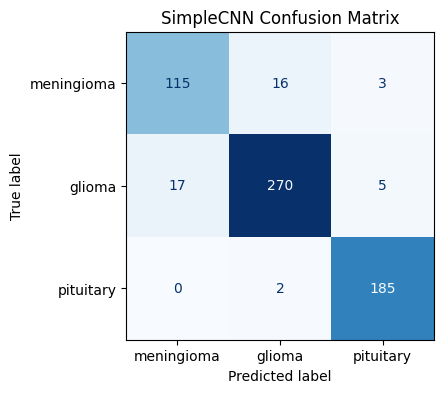

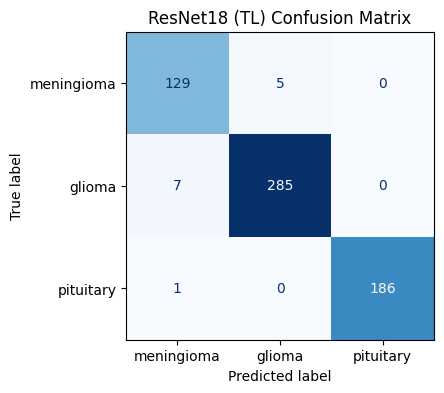

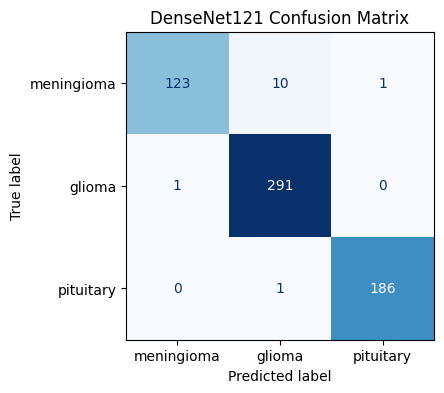

In [30]:
# Plotting confusion matrices for deep models
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_preds(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            # convert labels 1–3 -> 0–2
            all_preds.extend(preds)
            all_labels.extend((labels.numpy() - 1))
    return all_labels, all_preds

# SimpleCNN
y_true_cnn, y_pred_cnn = get_preds(model, test_loader)
# ResNet18
y_true_rn,  y_pred_rn  = get_preds(resnet,  test_loader_3c)
# DenseNet121
y_true_dn,  y_pred_dn  = get_preds(densenet, test_loader_3c)

deep_results = {
    "SimpleCNN":     (y_true_cnn, y_pred_cnn),
    "ResNet18 (TL)": (y_true_rn,  y_pred_rn),
    "DenseNet121":   (y_true_dn,  y_pred_dn),
}

for name, (true, pred) in deep_results.items():
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    plt.figure(figsize=(5,4))
    disp.plot(cmap="Blues", ax=plt.gca(), colorbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

rows = []
for name, (y_true, y_pred) in deep_results.items():
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    rows.append({
        'Model':    name,
        'Accuracy': f"{acc:.3f}",
        'Precision (wtd)': f"{prec:.3f}",
        'Recall (wtd)':    f"{rec:.3f}",
        'F1-score (wtd)':  f"{f1:.3f}"
    })

df_metrics = pd.DataFrame(rows)
display(df_metrics)


,Model,Accuracy,Precision (wtd),Recall (wtd),F1-score (wtd)
0,SimpleCNN,0.930,0.929,0.930,0.930
1,ResNet18 (TL),0.979,0.979,0.979,0.979
2,DenseNet121,0.979,0.979,0.979,0.979


In [32]:
# Deep Models 5-Fold Cross-Validation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedKFold
import numpy as np
from torchvision import transforms

# One-channel (grayscale) -> SimpleCNN
gray_tf = train_transform
gray_val = val_transform

# Three-channel -> pretrained nets
train_tf_3c = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_tf_3c = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


dataset_dir = os.path.join(project_dir, "brain_tumor_dataset")


# To store per-fold accuracy
deep_cv_results = {
    "SimpleCNN":     [],
    "ResNet18":      [],
    "DenseNet121":   []
}

# Loop over 5 folds
for fold, (train_idx, val_idx) in enumerate(folds, 1):
    print(f"\n===== Deep Models: Fold {fold} / 5 =====")

    # build Subset datasets for this fold
    ds_train_gray = Subset(BrainTumorMatH5Dataset(dataset_dir, gray_tf),  train_idx)
    ds_val_gray   = Subset(BrainTumorMatH5Dataset(dataset_dir, gray_val), val_idx)

    ds_train_3c = Subset(BrainTumorMatH5Dataset(dataset_dir, train_tf_3c), train_idx)
    ds_val_3c   = Subset(BrainTumorMatH5Dataset(dataset_dir, val_tf_3c),   val_idx)

    loader_train_gray = DataLoader(ds_train_gray, batch_size=32, shuffle=True,  num_workers=2)
    loader_val_gray   = DataLoader(ds_val_gray,   batch_size=32, shuffle=False, num_workers=2)

    loader_train_3c = DataLoader(ds_train_3c, batch_size=32, shuffle=True,  num_workers=2)
    loader_val_3c   = DataLoader(ds_val_3c,   batch_size=32, shuffle=False, num_workers=2)

    # SimpleCNN
    model_c = SimpleCNN(num_classes=3).to(device)
    optimizer_c = optim.Adam(model_c.parameters(), lr=1e-3)
    for epoch in range(5):
        train_model(model_c, loader_train_gray, criterion, optimizer_c, device)
    _, acc_c = evaluate_model(model_c, loader_val_gray, criterion, device)
    deep_cv_results["SimpleCNN"].append(acc_c)
    print(f"[Fold {fold}] SimpleCNN   -> val accuracy: {acc_c:.4f}")

    # ResNet18 (Transfer Learning)
    model_r = create_resnet18(num_classes=3).to(device)
    optimizer_r = optim.Adam(model_r.parameters(), lr=1e-4)
    for epoch in range(3):  # fewer epochs to save time
        train_model(model_r, loader_train_3c, criterion, optimizer_r, device)
    _, acc_r = evaluate_model(model_r, loader_val_3c, criterion, device)
    deep_cv_results["ResNet18"].append(acc_r)
    print(f"[Fold {fold}] ResNet18 (TL) -> val accuracy: {acc_r:.4f}")

    # DenseNet121 (Transfer Learning)
    model_d = create_densenet121(num_classes=3).to(device)
    optimizer_d = optim.Adam(model_d.parameters(), lr=1e-4)
    for epoch in range(3):
        train_model(model_d, loader_train_3c, criterion, optimizer_d, device)
    _, acc_d = evaluate_model(model_d, loader_val_3c, criterion, device)
    deep_cv_results["DenseNet121"].append(acc_d)
    print(f"[Fold {fold}] DenseNet121  -> val accuracy: {acc_d:.4f}")

# 5-fold results
print("\n===== Deep Models 5-Fold CV Summary =====")
for name, acc_list in deep_cv_results.items():
    mean_acc = np.mean(acc_list)
    std_acc  = np.std(acc_list)
    print(f"-> {name}: {mean_acc:.4f} ± {std_acc:.4f}")



===== Deep Models: Fold 1 / 5 =====
[Fold 1] SimpleCNN   -> val accuracy: 0.8581


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Fold 1] ResNet18 (TL) -> val accuracy: 0.9723


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Fold 1] DenseNet121  -> val accuracy: 0.9853

===== Deep Models: Fold 2 / 5 =====
[Fold 2] SimpleCNN   -> val accuracy: 0.8271
[Fold 2] ResNet18 (TL) -> val accuracy: 0.9527
[Fold 2] DenseNet121  -> val accuracy: 0.9739

===== Deep Models: Fold 3 / 5 =====
[Fold 3] SimpleCNN   -> val accuracy: 0.8467
[Fold 3] ResNet18 (TL) -> val accuracy: 0.9641
[Fold 3] DenseNet121  -> val accuracy: 0.9804

===== Deep Models: Fold 4 / 5 =====
[Fold 4] SimpleCNN   -> val accuracy: 0.8711
[Fold 4] ResNet18 (TL) -> val accuracy: 0.9608
[Fold 4] DenseNet121  -> val accuracy: 0.9706

===== Deep Models: Fold 5 / 5 =====
[Fold 5] SimpleCNN   -> val accuracy: 0.8627
[Fold 5] ResNet18 (TL) -> val accuracy: 0.9771
[Fold 5] DenseNet121  -> val accuracy: 0.9804

===== Deep Models 5-Fold CV Summary =====
-> SimpleCNN: 0.8531 ± 0.0152
-> ResNet18: 0.9654 ± 0.0086
-> DenseNet121: 0.9781 ± 0.0052


In [35]:
import numpy as np
import math

def paired_t_test(a, b):
    diff = np.array(a) - np.array(b)
    n     = diff.size
    mean  = diff.mean()
    sd    = diff.std(ddof=1)
    t     = mean / (sd / math.sqrt(n))
    return t, n-1

#DenseNet vs ResNet
t_dn_vs_rn, df = paired_t_test(deep_cv_results["DenseNet121"],
                               deep_cv_results["ResNet18"])
print(f"DenseNet vs ResNet  : t = {t_dn_vs_rn:.3f} (df={df})")
print("  Significant at 5 % level?"
      , "YES" if abs(t_dn_vs_rn) > 2.776 else "NO")

#HOG+KNN vs LBP+RF (classical)
t_hog_vs_lbp, df = paired_t_test(classic_fold_scores["HOG + KNN"],
                                 classic_fold_scores["LBP + RF"])
print(f"HOG+KNN vs LBP+RF   : t = {t_hog_vs_lbp:.3f} (df={df})")
print("  Significant at 5 % level?"
      , "YES" if abs(t_hog_vs_lbp) > 2.776 else "NO")


DenseNet vs ResNet  : t = 4.207 (df=4)
  Significant at 5 % level? YES
HOG+KNN vs LBP+RF   : t = 6.682 (df=4)
  Significant at 5 % level? YES
